# load model

In [1]:
from tensorflow import keras

conv_base = keras.applications.VGG16(weights='imagenet',
                                     include_top = False,
                                     input_shape = (150,150,3))

# Investigate Structure

In [2]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

# Method 1 (Utilizing convolutional base, no Densely connected Layer base)

In [3]:
import os 
import numpy as np
from tensorflow import keras

base_dir = os.path.abspath('/Users/jacob/OneDrive/Desktop/GitHub/Deep-Learning-With-Python-Exercises/cats_and_dogs_small')

os.chdir(base_dir)

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
batch_size = 20

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 4, 4, 512))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size = (150,150),
        batch_size = batch_size,
        class_mode = 'binary'
    )
    i = 0
    for inputs_batch, labels_batch  in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        labels[i * batch_size: (i + 1) *  batch_size] = labels_batch
        i += 1
        if i * batch_size>= sample_count:
            break
    return features, labels

train_features, train_labels = extract_features(train_dir, 2000)
validation_features, validation_labels = extract_features(validation_dir, 1000)
test_features, test_labels = extract_features(test_dir, 1000)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Flatten features to lower dimensionality

In [4]:
train_features = np.reshape(train_features, (2000, 4 * 4 * 512))
validation_features = np.reshape(validation_features, (1000, 4*4*512))
test_features = np.reshape(test_features, (1000, 4 * 4 * 512))

# Feed feature data into Densely  connected classifier

In [5]:
from tensorflow import keras

model = keras.models.Sequential()
model.add(keras.layers.Dense(256, activation='relu', input_dim=4*4*512))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer = keras.optimizers.RMSprop(lr=2e-5),
              loss = 'binary_crossentropy',
              metrics = ['acc'])

history = model.fit(train_features, train_labels, 
                    epochs = 30,
                    batch_size = 20,
                    validation_data = (validation_features, validation_labels))

Epoch 1/30
100/100 [==============================] - 4s 33ms/step - loss: 0.6713 - acc: 0.6191 - val_loss: 0.4336 - val_acc: 0.8400
Epoch 2/30
100/100 [==============================] - 2s 23ms/step - loss: 0.4456 - acc: 0.7815 - val_loss: 0.3563 - val_acc: 0.8610
Epoch 3/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3426 - acc: 0.8560 - val_loss: 0.3202 - val_acc: 0.8690
Epoch 4/30
100/100 [==============================] - 2s 23ms/step - loss: 0.3122 - acc: 0.8695 - val_loss: 0.2966 - val_acc: 0.8830
Epoch 5/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2715 - acc: 0.9009 - val_loss: 0.2812 - val_acc: 0.8900
Epoch 6/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2497 - acc: 0.8934 - val_loss: 0.2689 - val_acc: 0.8900
Epoch 7/30
100/100 [==============================] - 2s 23ms/step - loss: 0.2414 - acc: 0.9050 - val_loss: 0.2615 - val_acc: 0.8950
Epoch 8/30
100/100 [==============================] - 2s 23ms/step - 

# Plot results

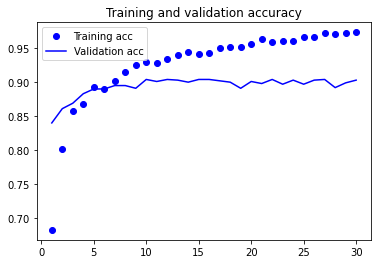

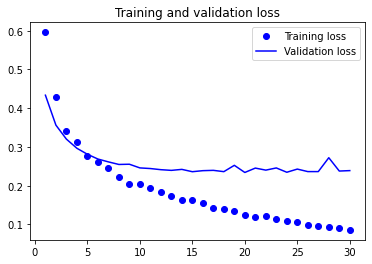

In [6]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Method 2 - Add densely connected layer on top of convolutional base

In [9]:
from tensorflow import keras
conv_base.trainable = False
model = keras.models.Sequential()
model.add(conv_base)
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(256, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

# Model summary

In [10]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


# Train model and freeze the convolutional base

In [12]:
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale= 1./255,
    rotation_range = 40, 
    width_shift_range = 0.2, 
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2, 
    horizontal_flip = True,
    fill_mode = 'nearest'
)

test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = (150, 150),
    batch_size = 20,
    class_mode = 'binary'
    
)

validation_generator = test_datagen.flow_from_directory(
    validation_dir,
    target_size = (150,150),
    batch_size = 20,
    class_mode = 'binary'
)




Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# Compile Model

In [13]:
model.compile(loss='binary_crossentropy',
              optimizer = keras.optimizers.RMSprop(lr = 2e-5),
             metrics = ['acc'])
history = model.fit_generator(train_generator,
                             steps_per_epoch = 100,
                             epochs = 30,
                             validation_data = validation_generator,
                             validation_steps = 50)

C:\Users\jacob\anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
100/100 [==============================] - 147s 1s/step - loss: 0.6356 - acc: 0.6400 - val_loss: 0.4560 - val_acc: 0.8290
Epoch 2/30
100/100 [==============================] - 142s 1s/step - loss: 0.5053 - acc: 0.7770 - val_loss: 0.3902 - val_acc: 0.8510
Epoch 3/30
100/100 [==============================] - 142s 1s/step - loss: 0.4353 - acc: 0.8167 - val_loss: 0.3406 - val_acc: 0.8510
Epoch 4/30
100/100 [==============================] - 145s 1s/step - loss: 0.4155 - acc: 0.8165 - val_loss: 0.3090 - val_acc: 0.8810
Epoch 5/30
100/100 [==============================] - 146s 1s/step - loss: 0.3906 - acc: 0.8220 - val_loss: 0.2912 - val_acc: 0.8930
Epoch 6/30
100/100 [==============================] - 157s 2s/step - loss: 0.3850 - acc: 0.8285 - val_loss: 0.2836 - val_acc: 0.8910
Epoch 7/30
100/100 [==============================] - 171s 2s/step - loss: 0.3566 - acc: 0.8418 - val_loss: 0.2777 - val_acc: 0.8910
Epoch 8/30
100/100 [==============================] - 159s 2s/step - 

# Plot Results

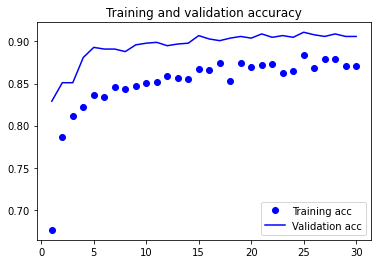

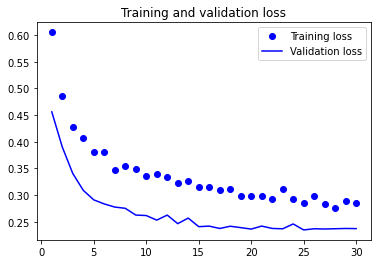

In [14]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label ='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

# Method 3 - Fine Tuning